In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 37.5 MB/s 
     |████████████████████████████████| 163 kB 55.9 MB/s 
     |████████████████████████████████| 7.6 MB 43.8 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import torch
import transformers as ppb
from transformers import AutoModel, AutoTokenizer 
import torch
from tqdm import tqdm, trange
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification
import numpy as np
import pandas as pd
import re

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, SimpleRNN,LSTM, Activation
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import transformers
import torch
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score, accuracy_score, average_precision_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt

In [4]:
import os
train_fname = f"/content/drive/MyDrive/CS3244/Final/Updated/full_train_preprocessed_subset.csv"

train = pd.read_csv(train_fname)
train = train.drop(columns=['Unnamed: 0'])

test_fname = f"/content/drive/MyDrive/CS3244/Final/Updated/full_test_preprocessed_subset.csv"
test = pd.read_csv(test_fname)
test = test.drop(columns=['Unnamed: 0'])

val_fname = f"/content/drive/MyDrive/CS3244/Final/Updated/full_val_preprocessed_subset.csv"
val = pd.read_csv(val_fname)
val = val.drop(columns=['Unnamed: 0'])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
def process(sen):
  if ":" in sen:
    sentence =sen[sen.index(":")+1:]
    return sentence
  return sen

def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

#Pre-processing
#train["tweets"] = train["tweets"].apply(process)
#train["tweets"] = test["tweets"].apply(process)

train["text"] = train["text"].apply(preprocess_text)
test["text"] = test["text"].apply(preprocess_text)
val['text'] = val['text'].apply(preprocess_text)

X_train = train['text']
Y_train = train['label']

X_test = test['text']
Y_test = test['label']

X_valid = val['text']
Y_valid = val['label']

In [6]:
bertweet = AutoModel.from_pretrained("vinai/bertweet-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization = True, use_fast=False)

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/843k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
def bert_encode(df, tokenizer):
    input_ids = []
    attention_masks = []
    for sent in df.values:
        encoded_dict = tokenizer.encode_plus(
                            sent,                      
                            add_special_tokens = True, 
                            max_length = 50,           
                            pad_to_max_length = True,
                            truncation = True,
                            return_attention_mask = True,   
                            return_tensors = 'pt',    
                    )
           
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return input_ids, attention_masks

In [8]:
print(Y_train[:])

0         2
1         2
2         2
3         2
4         2
         ..
133994    3
133995    3
133996    3
133997    3
133998    3
Name: label, Length: 133999, dtype: int64


In [9]:
def prepare_dataloaders(X_train,X_test, Y_train,Y_test,batch_size=8):
    # Load the AutoTokenizer with a normalization mode if the input Tweet is raw
    
    tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False, normalization=True)
    
    tweet_train = bert_encode(X_train, tokenizer)
    tweet_train_labels = Y_train
    
    tweet_test = bert_encode(X_test, tokenizer)
    #print(tweet_train)
    tweet_test_labels = Y_test

    input_ids = (tweet_train[0])
    attention_masks = (tweet_train[1])
    labels = torch.tensor(tweet_train_labels.values)
    train_dataset = TensorDataset(input_ids, attention_masks, labels)

    
    input_ids = (tweet_test[0])
    attention_masks = (tweet_test[1])
    labels = torch.tensor(tweet_test_labels.values)
    test_dataset = TensorDataset(input_ids, attention_masks,labels)

    
    train_dataloader = DataLoader(
                train_dataset,
                sampler = RandomSampler(train_dataset), 
                batch_size = batch_size 
            )


    test_dataloader = DataLoader(
                test_dataset, 
                sampler = SequentialSampler(test_dataset), 
                batch_size = batch_size
            )
    return train_dataloader, test_dataloader

In [10]:
print(bert_encode(X_train[0:1],tokenizer)[1])

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [11]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader,test_dataloader = prepare_dataloaders(X_train, X_test, Y_train, Y_test)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
from transformers import (get_linear_schedule_with_warmup,AdamW,AutoModel, AutoTokenizer,
                            AutoModelForSequenceClassification)
from torch.utils.data import (TensorDataset,DataLoader,
                             RandomSampler, SequentialSampler, Dataset)
warmup_proportion = 0.1
epochs = 5
num_training_steps  = len(train_dataloader) * epochs
num_warmup_steps = num_training_steps * warmup_proportion
def prepare_model(model_class="vinai/bertweet-base",num_classes=5,model_to_load=None,total_steps=-1):



    model = AutoModelForSequenceClassification.from_pretrained(
        model_class,
        num_labels = num_classes,  
        output_attentions = True, 
        output_hidden_states = True,
    )

    optimizer = AdamW(model.parameters(),
                    lr = 0.00002,
                    eps = 1e-8,
                     weight_decay = 1e-2
                    )
    '''scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, 
                                                num_training_steps = total_steps)'''
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

    if model_to_load is not None:
        try:
            model.roberta.load_state_dict(torch.load(model_to_load))
            print("LOADED MODEL")
        except:
            pass
    return model, optimizer, scheduler

In [15]:
epochs = 5
total_steps = len(train_dataloader) * epochs

model, optimizer, scheduler = prepare_model("vinai/bertweet-base" ,num_classes=5, model_to_load=None, total_steps = total_steps)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

In [16]:
#Without fine-tuning
train_dataloader

In [17]:
import time
from datetime import datetime
import datetime 

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))



def train(model,optimizer,scheduler,train_dataloader,epochs, device):
    model = model.to(device)
    training_stats = []
    total_t0 = time.time()

    for epoch_i in range(0, epochs):

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
        
        t0 = time.time()
        total_train_loss = 0
        model.train()
        for step, batch in enumerate(train_dataloader):
            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            model.zero_grad()        
            outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits
            total_train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
        avg_train_loss = total_train_loss / len(train_dataloader)            
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train(model,optimizer,scheduler,train_dataloader, epochs, device)


======== Epoch 1 / 5 ========
Training...
  Batch    40  of  16,750.    Elapsed: 0:00:10.
  Batch    80  of  16,750.    Elapsed: 0:00:15.
  Batch   120  of  16,750.    Elapsed: 0:00:19.
  Batch   160  of  16,750.    Elapsed: 0:00:25.
  Batch   200  of  16,750.    Elapsed: 0:00:32.
  Batch   240  of  16,750.    Elapsed: 0:00:37.
  Batch   280  of  16,750.    Elapsed: 0:00:42.
  Batch   320  of  16,750.    Elapsed: 0:00:47.
  Batch   360  of  16,750.    Elapsed: 0:00:52.
  Batch   400  of  16,750.    Elapsed: 0:00:57.
  Batch   440  of  16,750.    Elapsed: 0:01:02.
  Batch   480  of  16,750.    Elapsed: 0:01:07.
  Batch   520  of  16,750.    Elapsed: 0:01:12.
  Batch   560  of  16,750.    Elapsed: 0:01:17.
  Batch   600  of  16,750.    Elapsed: 0:01:23.
  Batch   640  of  16,750.    Elapsed: 0:01:31.
  Batch   680  of  16,750.    Elapsed: 0:01:36.
  Batch   720  of  16,750.    Elapsed: 0:01:42.
  Batch   760  of  16,750.    Elapsed: 0:01:48.
  Batch   800  of  16,750.    Elapsed: 0:01:5

In [28]:
torch.save(model.state_dict(), f"/content/drive/MyDrive/CS3244/Bertweet/bertTweet_model_try_3")

In [38]:
state = torch.load(f"/content/drive/MyDrive/CS3244/Bertweet/bertTweet_model_try_3")
model.load_state_dict(state)

In [30]:
def predict(model,test_dataloader):
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    preds = []
    
    with torch.no_grad():  

      for batch in test_dataloader:
          
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          #print(b_input_ids)
          #print(b_input_mask)
                
          outputs = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask)
          logits = outputs.logits

          logits = logits.detach().cpu().numpy()
          for logit in logits:
              preds.append(logit)

    return preds

In [31]:
print(test_dataloader)

In [41]:
result_1 = predict(model,test_dataloader)
from scipy.special import softmax

pred_labels_test = np.argmax(result_1, axis = 1)

In [33]:
#print(pred_labels[:])
print(pred_labels_test[:])

[2 1 4 ... 2 1 3]


In [36]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print(accuracy_score(Y_test,pred_labels_test))
print(classification_report(Y_test,pred_labels_test))


0.5017874934067866
              precision    recall  f1-score   support

           0       0.61      0.64      0.62      3934
           1       0.44      0.42      0.43      3546
           2       0.38      0.35      0.36      2911
           3       0.55      0.56      0.55      3619
           4       0.48      0.50      0.49      3053

    accuracy                           0.50     17063
   macro avg       0.49      0.49      0.49     17063
weighted avg       0.50      0.50      0.50     17063



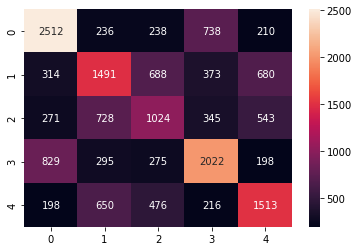

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
cf_matrix = confusion_matrix(Y_test,pred_labels_test)  
sb.heatmap(cf_matrix, annot=True, fmt='g')